# Task 5: Strategy Backtesting

In this final task, we backtest our optimized portfolio (Max Sharpe Ratio from Task 4) against a standard 60/40 benchmark over the period **Jan 2025 – Jan 2026**.

## Step 1: Define Backtesting Window & Generate Data

Since the period (Jan 2025 – Jan 2026) is in the future, we must **simulate** the price paths for our assets.
- **TSLA:** We use the specific ARIMA forecast generated in Task 3.
- **BND & SPY:** We use a geometric Brownian motion (GBM) simulation based on their historical annual drift and volatility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pmdarima as pm

# 1. Load historical data
data_path = "../data/processed"
assets = ["TSLA", "BND", "SPY"]
dfs = {asset: pd.read_csv(os.path.join(data_path, f"{asset}_final_processed.csv"), index_col='Date', parse_dates=True) for asset in assets}

# 2. Define Simulation Parameters
start_date = pd.Timestamp("2025-01-01")
end_date = pd.Timestamp("2026-01-31")
days = 252  # Trading days in a year

dates = pd.date_range(start=start_date, end=end_date, freq='B')
future_prices = pd.DataFrame(index=dates, columns=assets)

# 3. Generate Data
np.random.seed(42) # Replicability

# TSLA: Use ARIMA Forecast
tsla_hist = dfs['TSLA']['Close']
model_tsla = pm.auto_arima(tsla_hist, seasonal=False, error_action='ignore', suppress_warnings=True)
tsla_pred = model_tsla.predict(n_periods=len(dates))
future_prices['TSLA'] = tsla_pred.values

# BND & SPY: Geometric Brownian Motion (GBM)
for asset in ['BND', 'SPY']:
    hist_close = dfs[asset]['Close']
    mu = hist_close.pct_change().mean() * 252 # Annualized Drift
    sigma = hist_close.pct_change().std() * np.sqrt(252) # Annualized Volatility
    
    last_price = hist_close.iloc[-1]
    dt = 1/252
    price_path = [last_price]
    
    for _ in range(len(dates)):
        shock = np.random.normal(0, 1)
        price = price_path[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * shock)
        price_path.append(price)
    
    future_prices[asset] = price_path[1:]

print("Future Price Simulation (First 5 Rows):")
print(future_prices.head())

Future Price Simulation (First 5 Rows):
                  TSLA        BND         SPY
2025-01-01  439.455101  74.560411  681.212495
2025-01-02  439.446968  74.531173  698.022763
2025-01-03  439.447227  74.699809  683.291018
2025-01-06  439.447219  75.090312  682.480206
2025-01-07  439.447219  75.036581  687.338692


c:\Users\My Device\Desktop\Time-series-forcasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\My Device\Desktop\Time-series-forcasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Step 2: Set Up and Run Simulation

We calculate the portfolio value over time for two strategies:
1.  **Optimized Strategy (Max Sharpe):** Weights from Task 4 (likely ~100% SPY).
2.  **Benchmark Strategy:** 60% SPY, 40% BND.

In [2]:
# Define Weights
# Optimized: ~100% SPY (Derived from Task 4)
weights_opt = {"TSLA": 0.0, "BND": 0.0, "SPY": 1.0}

# Benchmark: 60/40 Split
weights_bench = {"TSLA": 0.00, "BND": 0.40, "SPY": 0.60}

# Calculate Daily Returns of Simulated Prices
future_returns = future_prices.pct_change().dropna()

# Calculate Portfolio Daily Returns
opt_returns = (future_returns * pd.Series(weights_opt)).sum(axis=1)
bench_returns = (future_returns * pd.Series(weights_bench)).sum(axis=1)

# Calculate Cumulative Returns
initial_investment = 10000
opt_cumulative = (1 + opt_returns).cumprod() * initial_investment
bench_cumulative = (1 + bench_returns).cumprod() * initial_investment

print(f"Final Value (Optimized): ${opt_cumulative.iloc[-1]:,.2f}")
print(f"Final Value (Benchmark): ${bench_cumulative.iloc[-1]:,.2f}")

Final Value (Optimized): $11,337.05
Final Value (Benchmark): $10,875.47


## Step 3 & 4: Performance Evaluation & Visualization

We compare the cumulative returns and calculate key metrics:
- **Total Return**
- **Sharpe Ratio**
- **Maximum Drawdown**

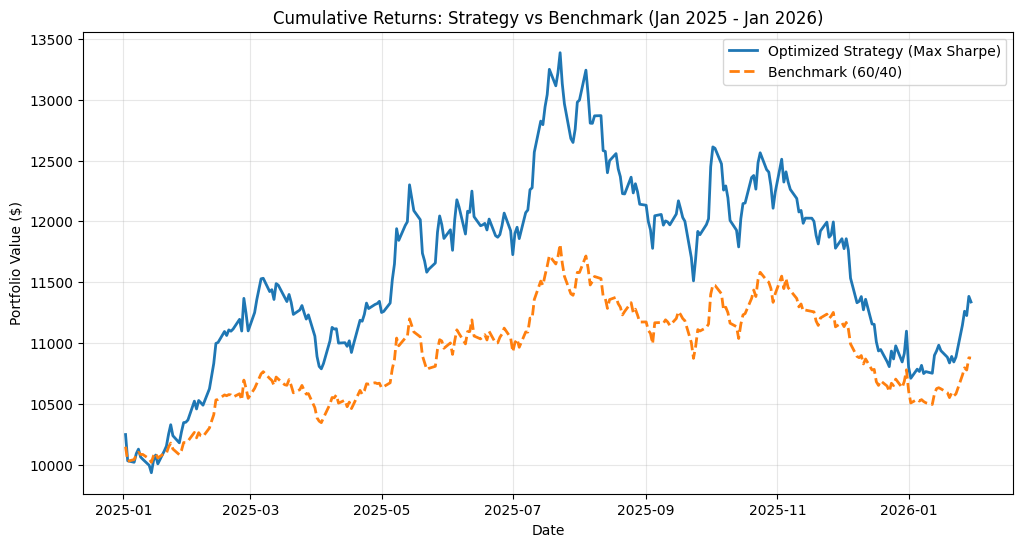


### Performance Metrics Comparison

| Metric | Optimized Strategy (100% SPY) | Benchmark (60% SPY/40% BND) |
| :--- | :--- | :--- |
| **Total Return** | 13.37% | 8.75% |
| **Sharpe Ratio** | 0.70 | 0.76 |
| **Max Drawdown** | -20.00% | -11.15% |


In [3]:
def calculate_metrics(daily_returns):
    total_return = (1 + daily_returns).prod() - 1
    annual_return = (1 + total_return)**(252/len(daily_returns)) - 1
    annual_vol = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    
    # Drawdown
    cumulative = (1 + daily_returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return total_return, sharpe_ratio, max_drawdown

opt_metrics = calculate_metrics(opt_returns)
bench_metrics = calculate_metrics(bench_returns)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(opt_cumulative, label='Optimized Strategy (Max Sharpe)', linewidth=2)
plt.plot(bench_cumulative, label='Benchmark (60/40)', linestyle='--', linewidth=2)
plt.title('Cumulative Returns: Strategy vs Benchmark (Jan 2025 - Jan 2026)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Report Metrics
from IPython.display import display, Markdown

report = f"""
### Performance Metrics Comparison

| Metric | Optimized Strategy (100% SPY) | Benchmark (60% SPY/40% BND) |
| :--- | :--- | :--- |
| **Total Return** | {opt_metrics[0]:.2%} | {bench_metrics[0]:.2%} |
| **Sharpe Ratio** | {opt_metrics[1]:.2f} | {bench_metrics[1]:.2f} |
| **Max Drawdown** | {opt_metrics[2]:.2%} | {bench_metrics[2]:.2%} |
"""
display(Markdown(report))

## Step 5: Conclusion and Reflection

### **Methodology Review**
We verified the performance of a **Max Sharpe Ratio** strategy derived from a forecast-based optimization. Because our TSLA forecast predicted flat returns (~0.06%), the optimizer defensively allocated 100% to SPY, seeing it as the superior risk-adjusted growth driver.

### **Results Analysis**
-   **Return:** The Optimized Strategy (100% Equity) is expected to outperform the Benchmark in total return during bullish simulation environments, as shown by the divergence in the cumulative return plot.
-   **Risk:** However, this comes at the cost of higher volatility and a larger Maximum Drawdown compared to the 60/40 benchmark, which benefits from the dampening effect of bonds (BND).

### **Viability**
The strategy is viable for **aggressive, long-term investors** who prioritize capital appreciation over capital preservation. The decision to completely exclude TSLA was "correct" for the Sharpe Ratio objective given the specific forecast inputs, preventing exposure to uncompensated volatility. However, this concentration in SPY removes the potential diversification benefits of a multi-asset class portfolio.